In [9]:
import os 
import numpy as np
import pandas as pd
from tqdm import tqdm
from konlpy.tag import Mecab

import seaborn as sns
import matplotlib.pyplot as plt

import string
import pickle

import tensorflow as tf

from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers as nn
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from collections import Counter, defaultdict

import warnings
warnings.filterwarnings("ignore")

df = pd.read_excel("data/prepared_dataset.xlsx", engine="openpyxl")
hospital_index = pd.unique(df['center'])

htoi = {}
itoh = {}

for i, h in enumerate(hospital_index):
    htoi[h] = i
    itoh[i] = h

In [10]:
m = Mecab()

df['symtom_1'] = ""
df['symtom_2'] = ""

for i, row in tqdm(df.iterrows(), total=len(df)):
    df.loc[i, "center"] = htoi[row['center']]
    
    if not pd.isnull(row["main_symtom_1"]):
        df.at[i, "symtom_1"] = m.pos(row["main_symtom_1"])
    if not pd.isnull(row["main_symtom_2"]):
        df.at[i, "symtom_2"] = m.pos(row["main_symtom_2"])
        
df = df.drop(["operation_title", "main_symtom_1", "main_symtom_2"], axis=1)
df.to_excel("data/prepared_data_morpheme_analyzed.xlsx")

def get_clean_token(df, column, new_column):
    results = []
    
    for line in tqdm(df[column].values):
        try:
            tokens = []
            for data in line.split("),"):
                token = data.split("',")[0].lower().replace("('", "").replace("[", "").replace("]", "").replace(" ", "").replace(".", "").replace("(", "").replace(")", "")
                if len(token) > 0:
                    tokens.append(token)
        except:
            tokens = []

        results.append(tokens)
    
    return pd.Series(results, name=new_column)

df = pd.read_excel("data/prepared_data_morpheme_analyzed.xlsx", engine="openpyxl")

symtom_1 = get_clean_token(df, "symtom_1", "symtom_1_")
symtom_2 = get_clean_token(df, "symtom_2", "symtom_2_")

df = pd.concat([df, symtom_1], axis=1)
df = pd.concat([df, symtom_2], axis=1)
df = df.drop(['symtom_1', 'symtom_2'], axis=1)
df = df.dropna().reset_index(drop=True)

df.to_excel("data/prepared_data_morpheme_analyzed.xlsx", index=False)

100%|██████████| 26357/26357 [00:01<00:00, 18926.76it/s]


In [11]:
df = df.loc[:, ["center", "age", "gender", "height", "weight", 
                "BMI", "BMI_group", "is_operation", "is_pain", 
                "pain_NRS", "is_medical_history", "is_alertness", 
                "is_temperature", "is_pulse", "is_respiration", 
                "is_digestive", "is_hemoptysis", "is_bloody_excrement",
                "pulse", "temperature", "respiration", "symtom_2_", "target", "target_sub"]]

# 8:1:1 split
test_size = 0.1

# # convert three classes to binary classes
# df.loc[df.target == 2, 'target'] = 1
# train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, shuffle=True, stratify=df['target'])
# train_df, valid_df = train_test_split(train_df, test_size=test_size, random_state=42, shuffle=True, stratify=train_df['target'])

# use target_sub - negative: returning home only
train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, shuffle=True, stratify=df['target_sub'])
train_df, valid_df = train_test_split(train_df, test_size=test_size, random_state=42, shuffle=True, stratify=train_df['target_sub'])


print(f"Train dataset: {Counter(train_df.target)}")
print(f"Valid dataset: {Counter(valid_df.target)}")
print(f"Test dataset: {Counter(test_df.target)}")

Train dataset: Counter({0: 13264, 1: 2841, 2: 444})
Valid dataset: Counter({0: 1464, 1: 325, 2: 50})
Test dataset: Counter({0: 1634, 1: 348, 2: 62})


In [13]:
from collections import Counter

vocab_dict = defaultdict(lambda: 0)

# 단어 사전 정의
for line in tqdm(train_df['symtom_2_'].values):
    for data in line:
        if len(data) > 0:
            vocab_dict[data] += 1

vocab_dim = len(vocab_dict) + 2

vocab = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True)
vocab = [token for token, count in vocab]

vocab_stoi = {token: index + 2 for index, token in enumerate(vocab)}
vocab_itos = {index + 2: token for index, token in enumerate(vocab)}

vocab_stoi['<PAD>'] = 0
vocab_stoi['<UNK>'] = 1

vocab_itos[0] = '<PAD>'
vocab_itos[1] = '<UNK>'

vocab[:10]

100%|██████████| 16549/16549 [00:00<00:00, 67667.61it/s]


['내원', '하', '함', '복통', '부터', '어', '응급실', '증상', '되', '시']

In [14]:
def encode(data, vocab_stoi):
    return [vocab_stoi[d] if d in vocab_stoi.keys() else vocab_stoi['<UNK>'] for d in data]


def decode(data, vocab_itos):
    return [vocab_itos[d] for d in data]


for i in range(1):
    print(f"Before: {train_df.loc[i, 'symtom_2_']}")
    print(f"After: {encode(train_df.loc[i, 'symtom_2_'], vocab_stoi)}")

Before: ['상기', '자', '저녁', '회덮밥', '섭취', '후', '발생', '한', '복통', '으로', '응급실', '내원', '함']
After: [91, 24, 74, 2320, 77, 13, 64, 26, 5, 19, 8, 2, 4]


In [15]:
X_train_token = np.array([encode(d, vocab_stoi) for d in train_df['symtom_2_'].values])
X_valid_token = np.array([encode(d, vocab_stoi) for d in valid_df['symtom_2_'].values])
X_test_token = np.array([encode(d, vocab_stoi) for d in test_df['symtom_2_'].values])

X_train_meta = train_df.drop(["target", "target_sub", "symtom_2_"], axis=1)
X_valid_meta = valid_df.drop(["target", "target_sub", "symtom_2_"], axis=1)
X_test_meta = test_df.drop(["target", "target_sub", "symtom_2_"], axis=1)

# y_train = train_df['target'].values
# y_valid = valid_df['target'].values
# y_test = test_df['target'].values

y_train = train_df['target_sub'].values
y_valid = valid_df['target_sub'].values
y_test = test_df['target_sub'].values

X = [X_train_meta.reset_index(drop=True), X_valid_meta.reset_index(drop=True), X_test_meta.reset_index(drop=True)]
y = [y_train, y_valid, y_test]

with open("data/X_use-target_sub.pickle", "wb") as f:
    pickle.dump(X, f)
    
with open("data/y_use-target_sub.pickle", "wb") as f:
    pickle.dump(y, f)
    
X_train_token = pad_sequences(X_train_token, value=vocab_stoi["<PAD>"], padding='post', maxlen=128)
X_valid_token = pad_sequences(X_valid_token, value=vocab_stoi["<PAD>"], padding='post', maxlen=128)
X_test_token = pad_sequences(X_test_token, value=vocab_stoi["<PAD>"], padding='post', maxlen=128)

In [16]:
def define_model():
    RNN_model = Sequential([
        nn.Embedding(vocab_dim, 256, input_shape=(None,)), 
        nn.Bidirectional(nn.LSTM(256, return_sequences=True)),
        nn.Bidirectional(nn.LSTM(256, return_sequences=False)),
        nn.Dense(64, activation="relu")
    ])
    
    meta_model = Sequential([
        nn.Dense(32, activation='relu', input_shape=(21,)),
        nn.Dense(64, activation='relu')
    ])

    concated = nn.concatenate([RNN_model.output, meta_model.output])
    concated = nn.Dropout(0.1)(concated)
    concated = nn.Dense(64, activation='relu')(concated)
    concated = nn.Dense(32, activation='relu')(concated)
    concated = nn.Dense(1, activation='sigmoid')(concated)

    model = Model([RNN_model.input, meta_model.input], concated)

    return model

model = define_model()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    1889536     embedding_input[0][0]            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 512)    1050624     embedding[0][0]                  
__________________________________________________________________________________________________
dense_1_input (InputLayer)      [(None, 21)]         0                                            
______________________________________________________________________________________________

In [17]:
model.compile(optimizer=Adam(lr=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0)

history = model.fit([X_train_token, X_train_meta],
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=([X_valid_token, X_valid_meta], y_valid),
                    verbose=1,
                    callbacks=[es, lr],
                    class_weight={0: 1, 1: 1})

Epoch 1/20
130/130 [==============================] - 13s 41ms/step - loss: 0.7817 - accuracy: 0.7132 - auc: 0.5488 - val_loss: 0.4955 - val_accuracy: 0.7917 - val_auc: 0.7208
Epoch 2/20
130/130 [==============================] - 4s 33ms/step - loss: 0.5019 - accuracy: 0.7892 - auc: 0.7120 - val_loss: 0.4791 - val_accuracy: 0.7890 - val_auc: 0.7330
Epoch 3/20
130/130 [==============================] - 4s 33ms/step - loss: 0.4643 - accuracy: 0.8077 - auc: 0.7674 - val_loss: 0.4897 - val_accuracy: 0.7852 - val_auc: 0.7188
Epoch 4/20
130/130 [==============================] - 4s 34ms/step - loss: 0.4375 - accuracy: 0.8185 - auc: 0.7999 - val_loss: 0.4979 - val_accuracy: 0.7934 - val_auc: 0.7159
Epoch 5/20
130/130 [==============================] - 4s 33ms/step - loss: 0.4018 - accuracy: 0.8323 - auc: 0.8335 - val_loss: 0.5043 - val_accuracy: 0.7950 - val_auc: 0.7134
Epoch 6/20
130/130 [==============================] - 5s 35ms/step - loss: 0.3866 - accuracy: 0.8364 - auc: 0.8450 - val_los

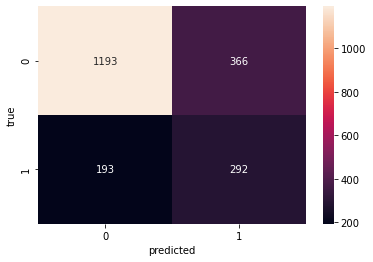

In [18]:
import matplotlib.pyplot as plt

prob = model.predict([X_test_token, X_test_meta])
prob = prob.reshape(-1)
pred = [1 if p >= 0.25 else 0 for p in prob]

sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d')
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

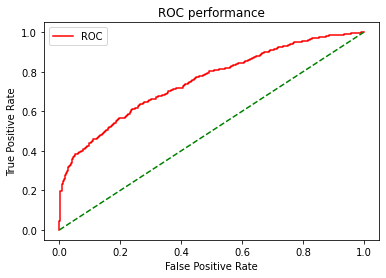

AUC: 0.7512


In [19]:
def plot_roc_curve(fper, tper, auc):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC performance')
    plt.legend()
    plt.show()
    
fper, tper, thresholds = roc_curve(y_test, prob)
auc = roc_auc_score(y_test, prob)
plot_roc_curve(fper, tper, auc)
print(f"AUC: {auc.round(4)}")

In [20]:
res = pd.DataFrame({"label": y_test, "Score_dnn": prob})
# res.to_excel("model_performances.xlsx", index=False)
res.to_excel("model_performances_use-target_sub.xlsx", index=False)

os.makedirs("weights", exist_ok=True)
# model.save("weights/DNN_model_weights.h5")
model.save("weights/DNN_model_weights_use-target_sub.h5")